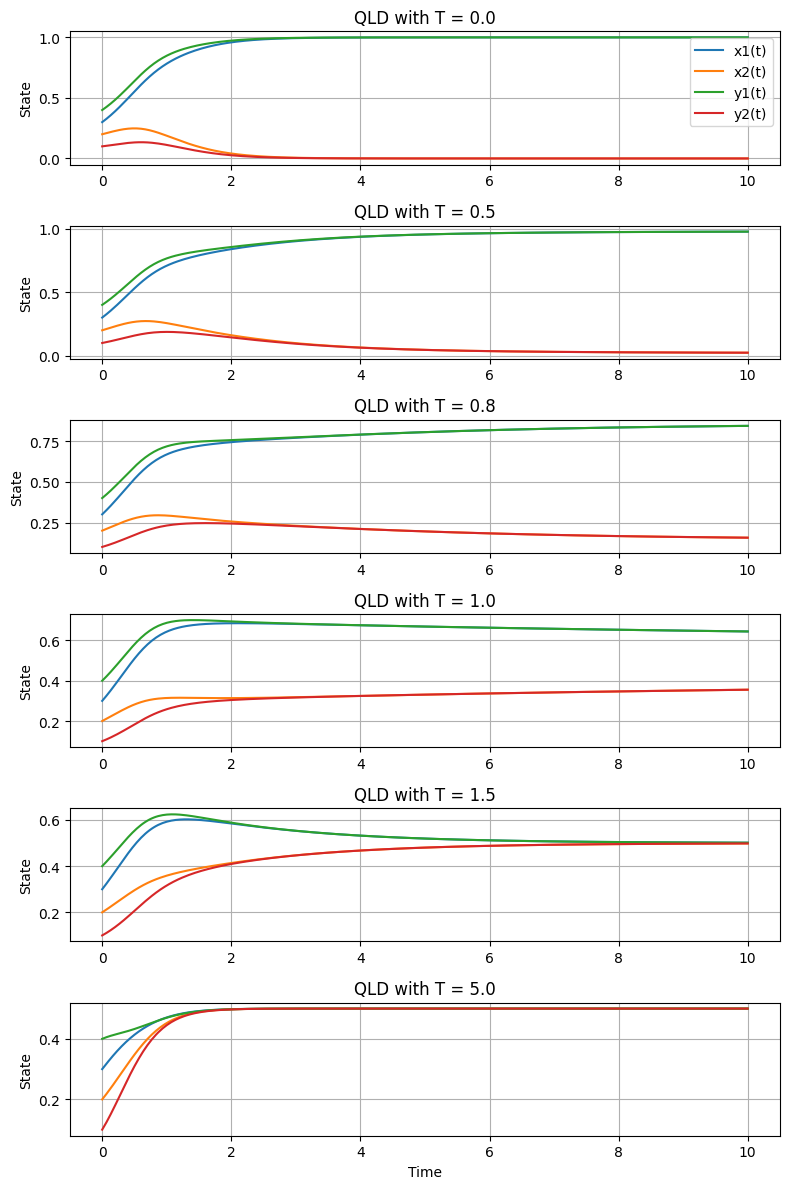

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def qlearning_system(state, t, T):
    """
    state = [x1, x2, y1, y2]
    Returns [dx1, dx2, dy1, dy2]
    """
    x1, x2, y1, y2 = state
    
    eps = 1e-10
    x1 = max(x1, eps)
    x2 = max(x2, eps)
    y1 = max(y1, eps)
    y2 = max(y2, eps)
    
    dx1 = x1*(6*y1 - 6*x1*y1 - 4*x2*y1 - 2*x2*y2 
              + T*x2*np.log(x2/x1))
    dx2 = x2*(4*y1 + 2*y2 - 6*x1*y1 - 4*x2*y1 - 2*x2*y2
              + T*x1*np.log(x1/x2))
    dy1 = y1*(6*x1 - 6*x1*y1 - 4*x1*y2 - 2*x2*y2
              + T*y2*np.log(y2/y1))
    dy2 = y2*(4*x1 + 2*x2 - 6*x1*y1 - 4*x1*y2 - 2*x2*y2
              + T*y1*np.log(y1/y2))
    return [dx1, dx2, dy1, dy2]


# Values of T to try
T_values = [0.0, 0.5, 0.8, 1.0, 1.5, 5.0]

# Time range
t = np.linspace(0, 10, 300)

# Initial condition (strictly positive to avoid log(0))
init_state = [0.3, 0.2, 0.4, 0.1]

# Create one figure for all subplots
plt.figure(figsize=(8, 12)) 

for i, T in enumerate(T_values, start=1):
    sol = odeint(qlearning_system, init_state, t, args=(T,))
    x1_sol = sol[:, 0]
    x2_sol = sol[:, 1]
    y1_sol = sol[:, 2]
    y2_sol = sol[:, 3]
    
    # Create a subplot in a column of length(T_values)
    plt.subplot(len(T_values), 1, i)
    plt.plot(t, x1_sol, label='x1(t)')
    plt.plot(t, x2_sol, label='x2(t)')
    plt.plot(t, y1_sol, label='y1(t)')
    plt.plot(t, y2_sol, label='y2(t)')
    plt.title(f'QLD with T = {T}')
    plt.ylabel('State')
    plt.grid(True)
    if i == 1:
        plt.legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()

/var/folders/7b/vp67hkx169q21m1g8l1_vpp40000gn/T/ipykernel_67200/801254638.py:45: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  sol = fsolve(system, guess)


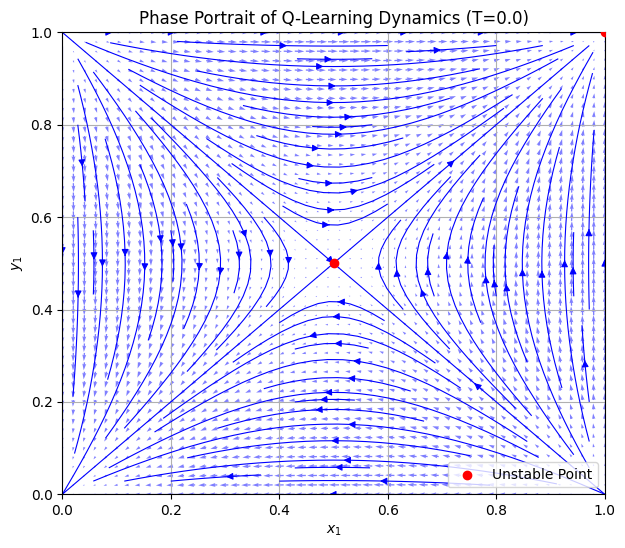

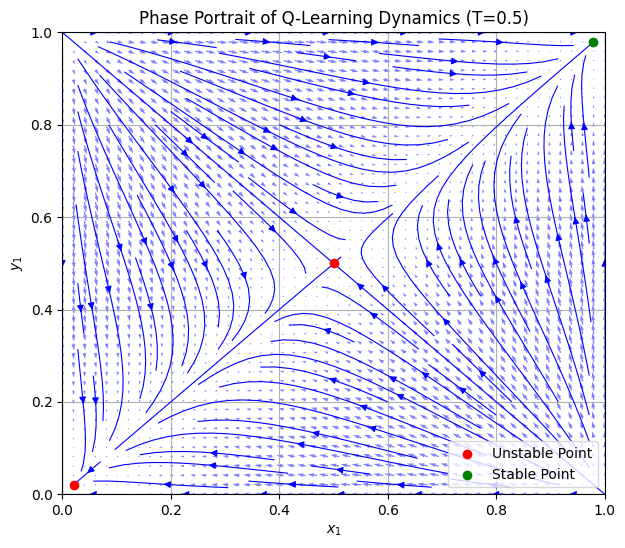

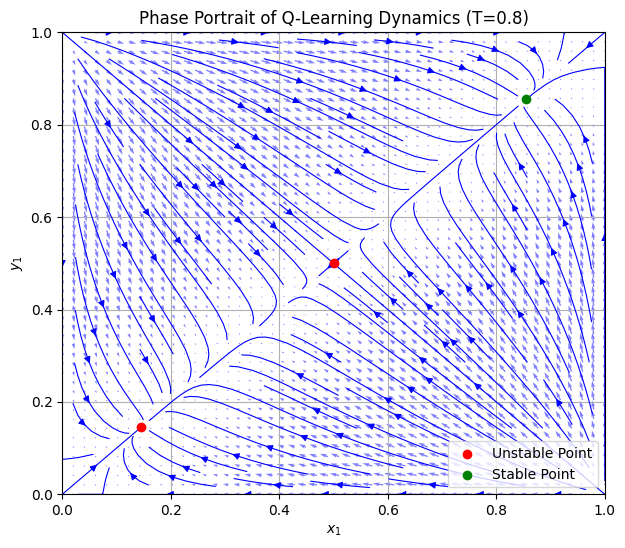

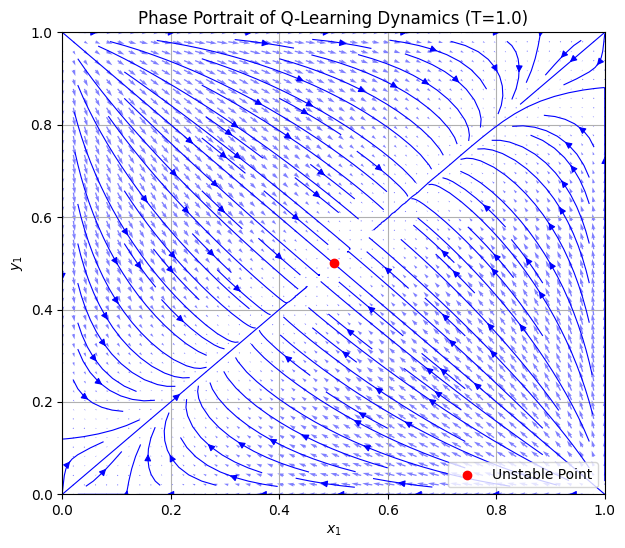

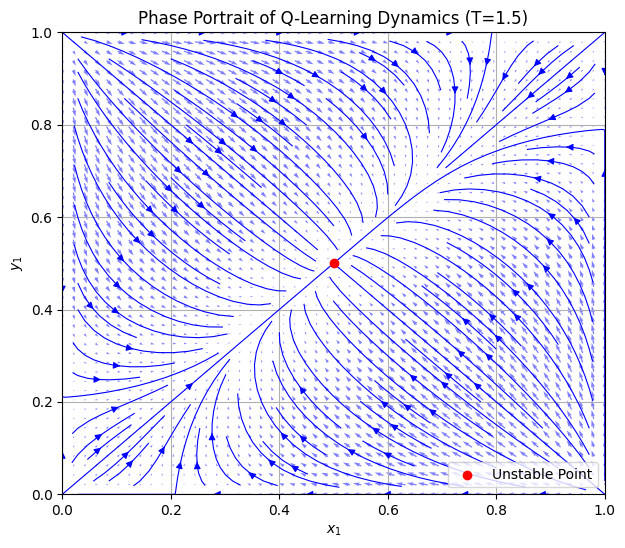

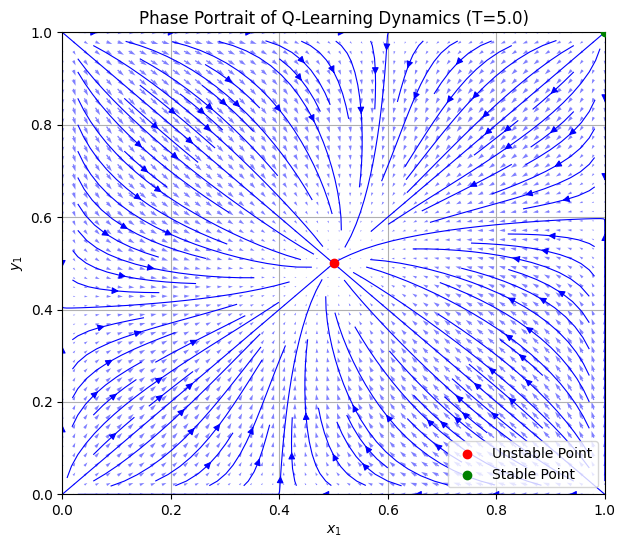

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.linalg import eigvals

def qld_2x2_field(xy, T):
    """
    xy = (x1,y1), with x2=1-x1, y2=1-y1.
    Return (dx1, dy1) from the Q-Learning ODE.
    """
    x1, y1 = xy
    x2 = 1.0 - x1
    y2 = 1.0 - y1

    # Avoid log(0) if x1=0, etc.:
    eps = 1e-12
    x1 = max(x1, eps)
    x2 = max(x2, eps)
    y1 = max(y1, eps)
    y2 = max(y2, eps)

    # Q-Learning formula for dx1, dy1
    dx1 = x1*(6*y1 - 6*x1*y1 - 4*x2*y1 - 2*x2*y2
              + T*x2*np.log(x2/x1))

    dy1 = y1*(6*x1 - 6*x1*y1 - 4*x1*y2 - 2*x2*y2
              + T*y2*np.log(y2/y1))

    return dx1, dy1

def compute_rest_points(T):
    """
    Find rest points of the Q-Learning Dynamics.
    """
    def system(variables):
        x1, y1 = variables
        dx1, dy1 = qld_2x2_field((x1, y1), T)
        return [dx1, dy1]

    # Initial guesses for fixed points
    guesses = [(0.1, 0.1), (0.5, 0.5), (0.9, 0.9)]
    rest_points = []
    
    for guess in guesses:
        sol = fsolve(system, guess)
        # Check if the solution is valid and not already found
        if all(0 <= sol[i] <= 1 for i in range(2)) and not any(np.allclose(sol, rp, atol=1e-4) for rp in rest_points):
            rest_points.append(sol)
    
    return np.array(rest_points)

def classify_rest_points(rest_points, T):
    """
    Classify rest points as stable or unstable.
    """
    stability = []
    for point in rest_points:
        x1, y1 = point
        x2 = 1 - x1
        y2 = 1 - y1

        # Jacobian matrix for the system
        J = np.array([
            [6*y1 - 12*x1*y1 - 4*x2*y1 - 2*x2*y2 + T*(1 + np.log(x2/x1)), 
             6*x1 - 6*x1**2 - 4*x1*x2 - 2*x1*y2],
            [6*y1 - 6*y1**2 - 4*x1*y1 - 2*x2*y1, 
             6*x1 - 6*x1*y1 - 4*x1*y2 - 2*x2*y2 + T*(1 + np.log(y2/y1))]
        ])

        # Compute eigenvalues
        eigenvalues = eigvals(J)
        if np.all(np.real(eigenvalues) < 0):
            stability.append("stable")
        else:
            stability.append("unstable")
    return stability

def plot_phase_portrait_for_T(T, N=50):
    """
    Plot a streamplot and mark stable and unstable rest points for Q-Learning Dynamics.
    """
    xs = np.linspace(0, 1, N)
    ys = np.linspace(0, 1, N)
    XX, YY = np.meshgrid(xs, ys)
    UU = np.zeros_like(XX)
    VV = np.zeros_like(YY)

    for i in range(N):
        for j in range(N):
            x1 = XX[i, j]
            y1 = YY[i, j]
            dx1, dy1 = qld_2x2_field((x1, y1), T)
            UU[i, j] = dx1
            VV[i, j] = dy1

    # Compute rest points and classify them
    rest_points = compute_rest_points(T)
    stability = classify_rest_points(rest_points, T)

    plt.figure(figsize=(7, 6))
    plt.streamplot(XX, YY, UU, VV, color='blue', linewidth=0.8, density=1.2)
    plt.quiver(XX, YY, UU, VV, color='blue', alpha=0.5)

    # Highlight rest points
    if len(rest_points) > 0:
        for i, point in enumerate(rest_points):
            x, y = point
            if stability[i] == "stable":
                plt.scatter(x, y, color='green', label='Stable Point', zorder=5)
            else:
                plt.scatter(x, y, color='red', label='Unstable Point', zorder=5)

    # Ensure no duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title(f"Phase Portrait of Q-Learning Dynamics (T={T})")
    plt.xlabel("$x_1$")
    plt.ylabel("$y_1$")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

def main():
    # Example T values to explore
    T_values = [0.0, 0.5, 0.8, 1.0, 1.5, 5.0]

    for T in T_values:
        plot_phase_portrait_for_T(T, N=50)

if __name__ == "__main__":
    main()

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import os

def plot_on_simplex(traj, filename):
    """
    Plot trajectories on a simplex.
    traj: shape (3, timesteps, num_trajectories), probabilities over three actions.
    """
    proj = np.array([
        [-1 * np.cos(30 / 360 * 2 * np.pi), np.cos(30 / 360 * 2 * np.pi), 0],
        [-1 * np.sin(30 / 360 * 2 * np.pi), -1 * np.sin(30 / 360 * 2 * np.pi), 1]
    ])

    ts = np.linspace(0, 1, 10000)
    e1 = proj @ np.array([ts, 1 - ts, 0 * ts])
    e2 = proj @ np.array([0 * ts, ts, 1 - ts])
    e3 = proj @ np.array([ts, 0 * ts, 1 - ts])

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(e1[0], e1[1], 'k-', alpha=0.3)
    ax.plot(e2[0], e2[1], 'k-', alpha=0.3)
    ax.plot(e3[0], e3[1], 'k-', alpha=0.3)

    for i in range(traj.shape[2]):
        d = proj @ traj[:3, :, i]
        ax.plot(d[0], d[1], '--', alpha=0.6)

    plt.axis('off')
    plt.savefig(filename)
    plt.close()

def q_learning_dynamics(state, t, A, B, T):
    """
    Q-Learning dynamics for a 3x3 game.
    state: (6,) array, where first 3 elements are row player's strategy,
           and last 3 are column player's strategy.
    A, B: payoff matrices for row and column players, respectively.
    T: temperature parameter.
    """
    x, y = state[:3], state[3:]
    dx = np.zeros(3)
    dy = np.zeros(3)

    Ax = A @ y
    xAx = x @ Ax
    By = B.T @ x
    yBy = y @ By

    for i in range(3):
        dx[i] = x[i] * (Ax[i] - xAx + T * sum(x[j] * np.log(x[j] / x[i]) for j in range(3)))
        dy[i] = y[i] * (By[i] - yBy + T * sum(y[j] * np.log(y[j] / y[i]) for j in range(3)))

    return np.concatenate([dx, dy])

# Define the game matrix A, B with epsilon
def define_game_matrix(epsilon_X, epsilon_Y):
    A = np.array([
        [epsilon_X, -1, 1],
        [1, epsilon_X, -1],
        [-1, 1, epsilon_X]
    ])
    B = np.array([
        [epsilon_Y, 1, -1],
        [-1, epsilon_Y, 1],
        [1, -1, epsilon_Y]
    ])
    return A, B

# Simulation parameters
T_values = [0.0, 0.1, 0.5, 0.8]
epsilon_X_values = [-0.1, 0.0, 0.1]
epsilon_Y_values = [-0.1, 0.0, 0.1]
timesteps = np.linspace(0, 100, 500)
num_trajectories = 10

# Prepare directories for saving simplex plots
os.makedirs("SimplexPlots", exist_ok=True)

# Loop over different parameter combinations
for T in T_values:
    for epsilon_X in epsilon_X_values:
        for epsilon_Y in epsilon_Y_values:
            # Define game matrices
            A, B = define_game_matrix(epsilon_X, epsilon_Y)

            # Generate trajectories
            all_sol = np.zeros((6, len(timesteps), num_trajectories))
            for i in range(num_trajectories):
                x0 = np.random.dirichlet(np.ones(3))
                y0 = np.random.dirichlet(np.ones(3))
                state0 = np.concatenate([x0, y0])
                sol = odeint(q_learning_dynamics, state0, timesteps, args=(A, B, T))
                all_sol[:, :, i] = sol.T

            # Project row player (x) strategy onto simplex
            filename = f"SimplexPlots/Simplex_T{T}_eX{epsilon_X}_eY{epsilon_Y}.png"
            plot_on_simplex(all_sol[:3, :, :], filename)